In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,Conv2D,BatchNormalization,Input,MaxPooling2D,ReLU
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(rescale = 1/255,shear_range = 0.2, zoom_range = 0.2,horizontal_flip = True, validation_split = 0.1)
path = r'.\data\Train_cartoon'
train_generator = train_datagen.flow_from_directory(path,target_size=(224, 224),subset = 'training')
validation_generator = train_datagen.flow_from_directory(path,target_size=(224, 224),subset = 'validation')

Found 3567 images belonging to 6 classes.
Found 392 images belonging to 6 classes.


In [3]:
def create_model():
    input_A = Input(shape = (224,224,3))
    x = Conv2D(filters = 64, strides = 2, kernel_size = 3, activation= 'elu')(input_A)
    x = MaxPooling2D(2)(x)
    x = Conv2D(filters = 128, strides = 1, kernel_size = 3, activation= 'elu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(filters = 256, strides = 1, kernel_size = 3, activation= 'elu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(filters = 512, strides = 1, kernel_size = 3, activation= 'elu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    output = Dense(6,activation = 'softmax')(x)
    model = Model(input_A,output)
    return model

In [4]:
early_stopping_cb = EarlyStopping(patience = 20)
checkpoint_cb = ModelCheckpoint('model3.h5', save_best_only = True)
model = create_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 256)       0   

In [5]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 100, callbacks = [checkpoint_cb,early_stopping_cb])

Epoch 1/100
112/112 [==============================] - 73s 648ms/step - loss: 1.7891 - accuracy: 0.2414 - val_loss: 1.4475 - val_accuracy: 0.2653
Epoch 2/100
112/112 [==============================] - 70s 628ms/step - loss: 1.6780 - accuracy: 0.2857 - val_loss: 1.6417 - val_accuracy: 0.3189
Epoch 3/100
112/112 [==============================] - 70s 627ms/step - loss: 1.6533 - accuracy: 0.3157 - val_loss: 2.0919 - val_accuracy: 0.3699
Epoch 4/100
112/112 [==============================] - 70s 628ms/step - loss: 1.6033 - accuracy: 0.3703 - val_loss: 1.5427 - val_accuracy: 0.4260
Epoch 5/100
112/112 [==============================] - 70s 629ms/step - loss: 1.4926 - accuracy: 0.4188 - val_loss: 1.5610 - val_accuracy: 0.4439
Epoch 6/100
112/112 [==============================] - 70s 627ms/step - loss: 1.4009 - accuracy: 0.4659 - val_loss: 1.1526 - val_accuracy: 0.4847
Epoch 7/100
112/112 [==============================] - 71s 630ms/step - loss: 1.3448 - accuracy: 0.4999 - val_loss: 1.5948 -

Epoch 57/100
112/112 [==============================] - 70s 628ms/step - loss: 0.0924 - accuracy: 0.9669 - val_loss: 0.0202 - val_accuracy: 0.9515
Epoch 58/100
112/112 [==============================] - 70s 627ms/step - loss: 0.0758 - accuracy: 0.9756 - val_loss: 0.0010 - val_accuracy: 0.9541
Epoch 59/100
112/112 [==============================] - 70s 626ms/step - loss: 0.0627 - accuracy: 0.9787 - val_loss: 0.0762 - val_accuracy: 0.9490
Epoch 60/100
112/112 [==============================] - 70s 626ms/step - loss: 0.0574 - accuracy: 0.9804 - val_loss: 0.1055 - val_accuracy: 0.9566
Epoch 61/100
112/112 [==============================] - 70s 626ms/step - loss: 0.0678 - accuracy: 0.9787 - val_loss: 0.0012 - val_accuracy: 0.9617
Epoch 62/100
112/112 [==============================] - 70s 625ms/step - loss: 0.0642 - accuracy: 0.9793 - val_loss: 0.0330 - val_accuracy: 0.9490
Epoch 63/100
112/112 [==============================] - 70s 627ms/step - loss: 0.0986 - accuracy: 0.9664 - val_loss: 1

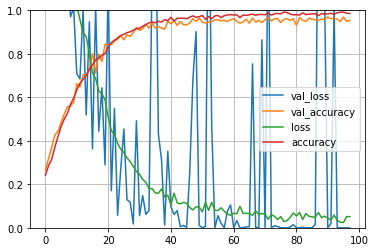

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training_accuracy(history):
    pd.DataFrame(history.history).plot()
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_training_accuracy(history)

In [8]:
test_gen = ImageDataGenerator(rescale = 1/255)
path = r'.\data\Test_cartoon'
test_generator = test_gen.flow_from_directory(path,target_size=(224, 224))

model.evaluate(test_generator)

Found 1031 images belonging to 6 classes.
33/33 [==============================] - 4s 136ms/step


[1.6126576662063599, 0.7565470337867737]